## Light curve from TESS for TIC43529091

TIC43529091 has been identified using GALAH and WiFeS spectra to likely be a double-generate single-line spectroscopic binary. The visible star is an extremely low mass white dwarf ($\mathrm{mass} < 0.3 M_\odot$).

This code creates the publication plot of the TESS cutout, light curve, periodgram, and folded light curve.

This is adapted from a notebook provided to me by Ben Montet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import astropy.units as u
import seaborn as sns
import matplotlib.ticker as mticker
import lightkurve
from lightkurve.lightcurve import LightCurve as LC
import pandas as pd
import matplotlib.ticker as ticker
import corner
from IPython.display import display, Math
import emcee
from astropy.timeseries import LombScargle

%config InlineBackend.figure_format = 'retina'

This step downloads the appropriate cutout region of the FFIs for all sectors the target is observed

In [14]:
star = eleanor.multi_sectors(tic=43529091, sectors=[5])

INFO: Found cached file /Users/jeffrey/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-3-cal-1098-0430_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-3-cal-1098-0430_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]
INFO: Found cached file /Users/jeffrey/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-3-cal-1098-0430_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-3-cal-1098-0430_tess_v2_pc.fits with expected size 147421440. [astroquery.query]


In [15]:
the_star = star[0]
print(the_star.coords, the_star.position_on_chip)

[75.2160469241695, -9.51530390369614] [1140.89299922  416.54481551]


Star is a list of `eleanor.Source()` objects, one for each sector. There's only one sector of data for this target, it's a list of length one.

This step does the processing.

In [16]:
data = eleanor.TargetData(the_star, do_pca=True, crowded_field=True)#, height=50, width=50)

Set DATE-BEG to '2018-11-15T11:37:07.696' from MJD-BEG'. [astropy.wcs.wcs]


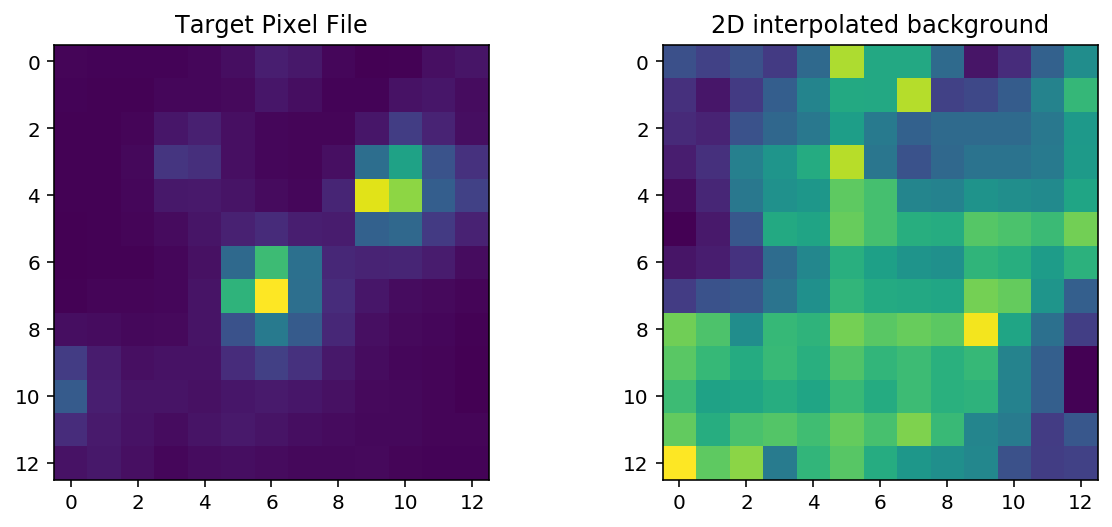

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.bkg_tpf[0])
ax2.set_title('2D interpolated background');

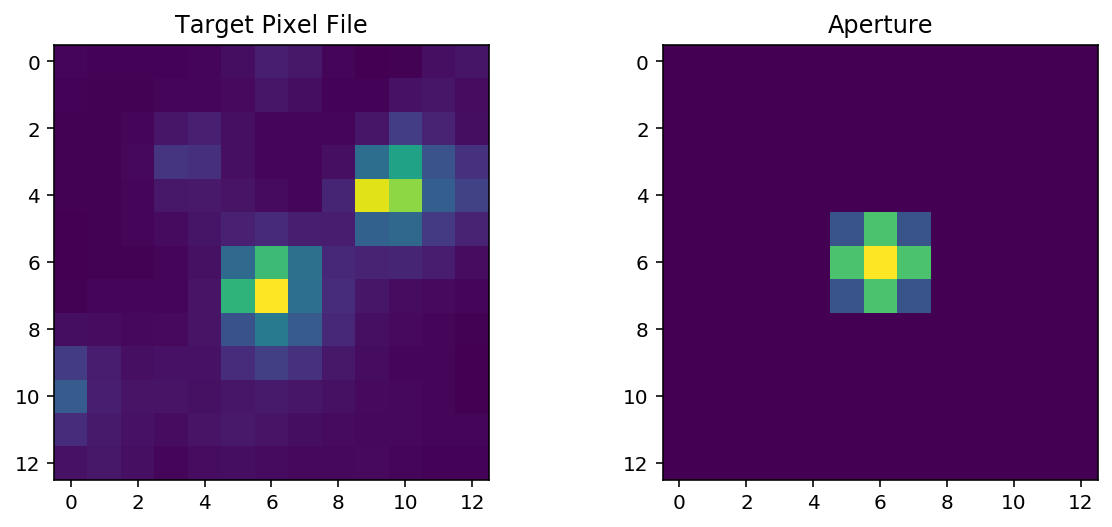

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.aperture)
ax2.set_title('Aperture');

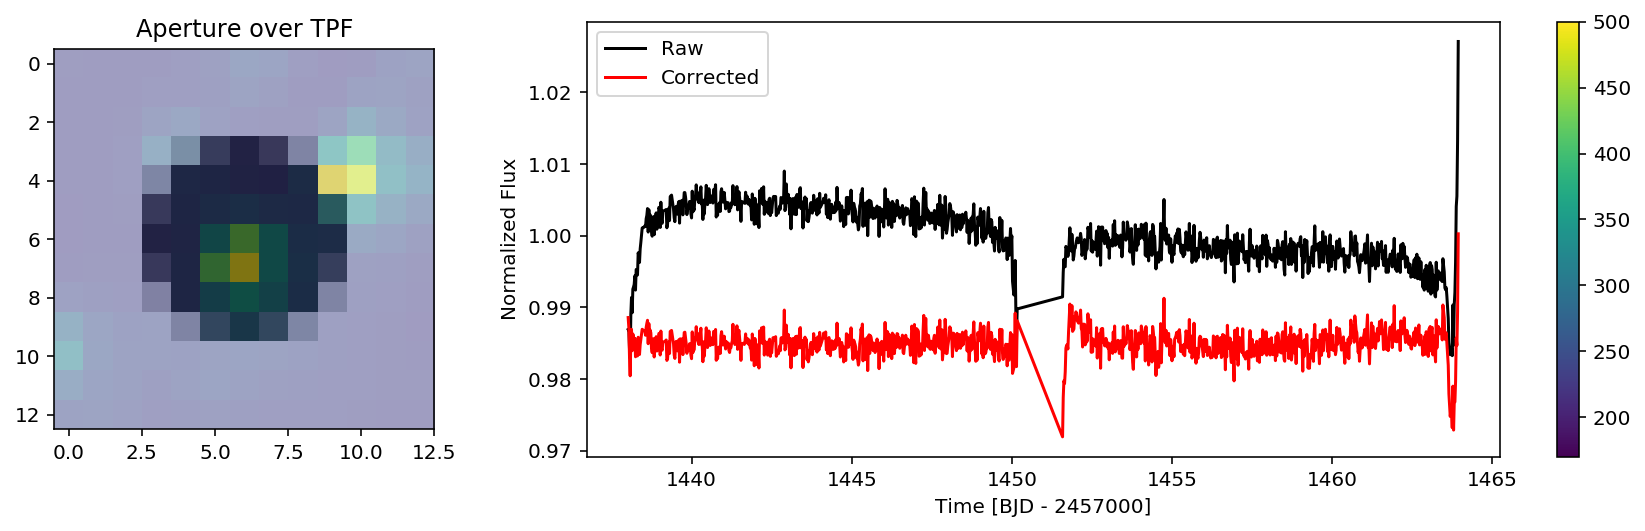

In [19]:
from matplotlib.colors import LogNorm
q= data.quality == 0

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
cm = ax1.imshow(data.tpf[0], vmin=170, vmax=500)
ax1.imshow(data.all_apertures[16], cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
plt.colorbar(cm)

ax2.plot(data.time[q], data.all_raw_flux[16][q]/np.nanmedian(data.all_raw_flux[16][q]), 'k', label='Raw')
ax2.plot(data.time[q], data.all_corr_flux[16][q]/np.nanmedian(data.all_corr_flux[16][q]) - 0.015, 'r', label='Corrected')
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux')
ax2.legend();

Let's look at the light curves! `raw_flux` is the background-subtracted light curve but no other processing applied.

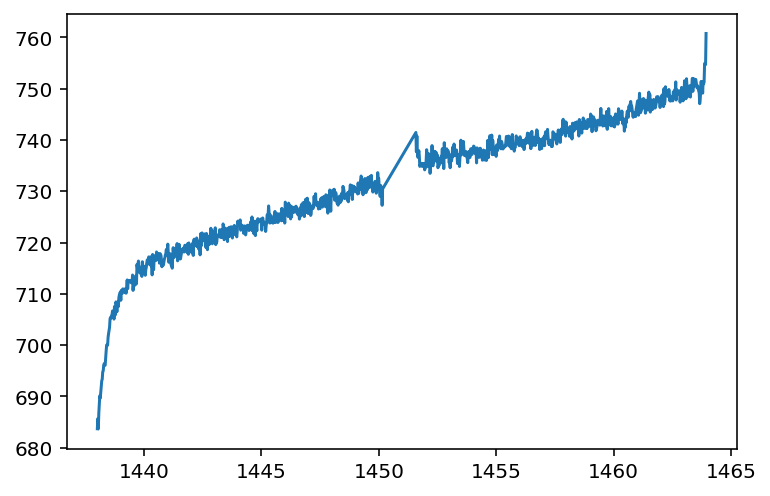

In [20]:
plt.plot(data.time[q], data.raw_flux[q])

`corr_flux` is the corrected flux, accounting for things like spacecraft jitter, shared systematics with nearby stars, long-term spacecraft thermal effects, etc. This is where the magic happens.

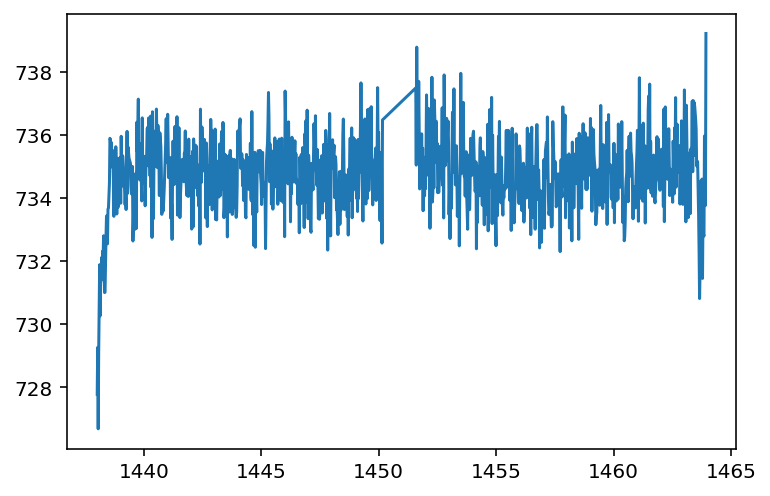

In [21]:
plt.plot(data.time[q], data.corr_flux[q])

It looks like there's a little extra magic right at the start and end of the sector. These are each at Earth perigee when the scattered light from the earth is at its worst and messes with our background models. I'm arbitrarily going to remove the first and last few cadences---from both ends---plus a few in the middle.

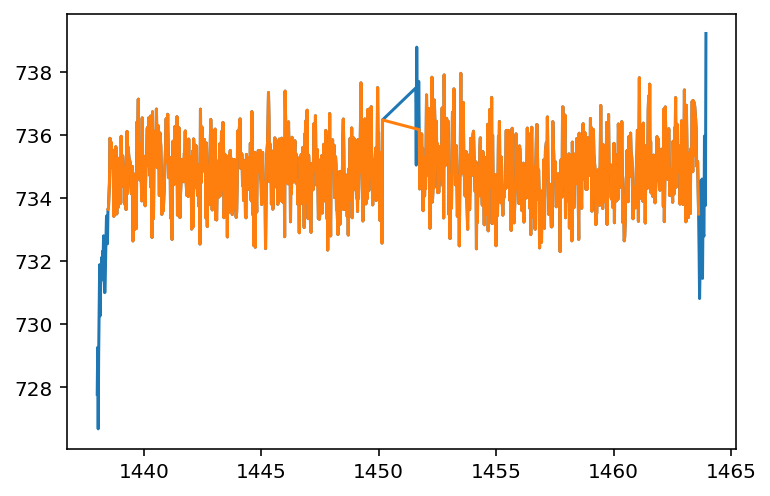

In [22]:
useful_cadences = ((data.time > 1438.47) & 
                   (data.time < 1463.63) &
                   ~((data.time > 1450.2) & (data.time < 1451.71)))

plt.plot(data.time[q],
         data.corr_flux[q])
plt.plot(data.time[q & useful_cadences],
         data.corr_flux[q & useful_cadences])

In [23]:
len(data.time[q & useful_cadences]), len(data.time[q & ~useful_cadences])

(1089, 43)

Construct a lightkurve LC object, with the time information adjusted to a new zero

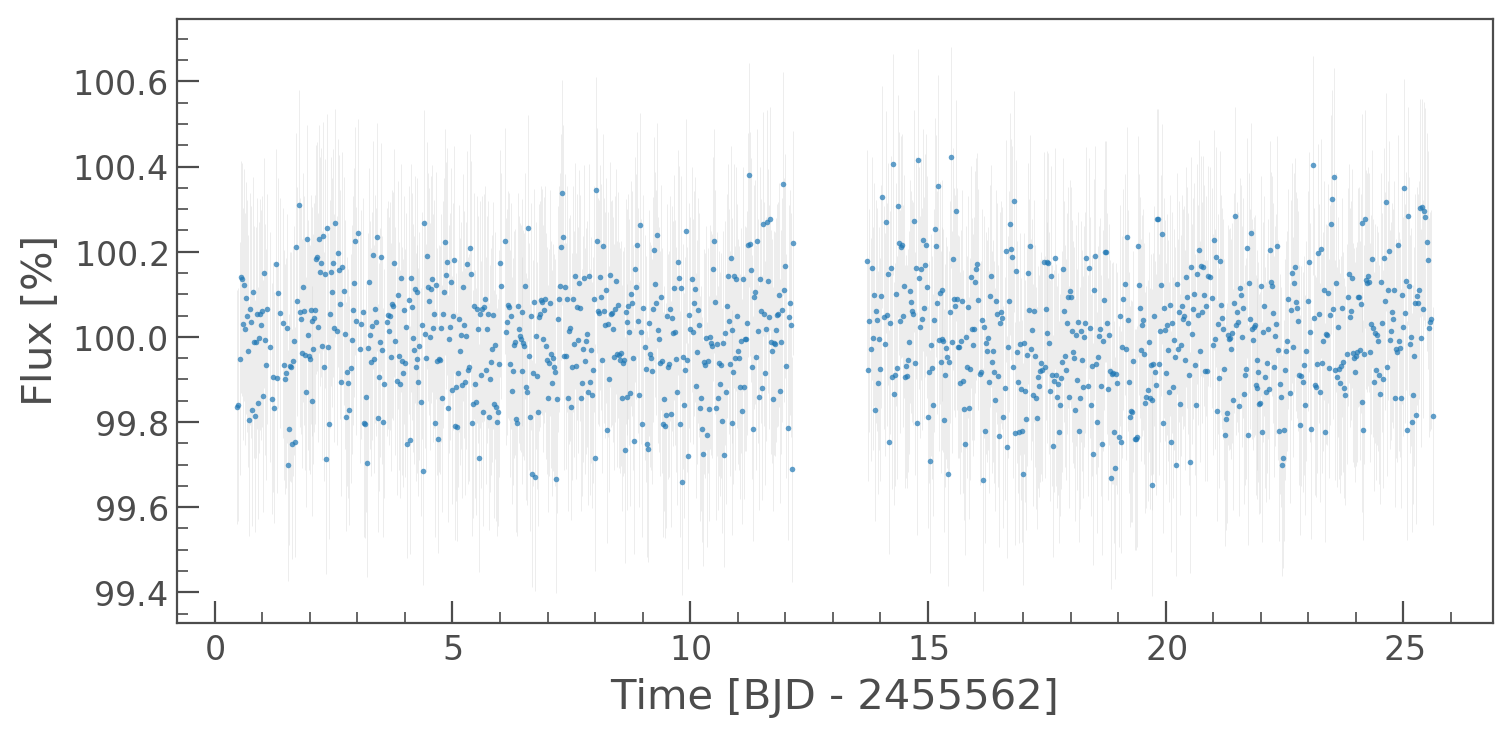

In [24]:
lk = LC(data.time[q & useful_cadences] - 1438,
        data.corr_flux[q & useful_cadences],
        (data.flux_err/data.raw_flux*data.flux_err)[q & useful_cadences])

error_kwargs = dict(fmt='.', ecolor='lightgray', elinewidth=0.2, markersize=4., alpha=0.7, markeredgewidth=0)
# Plot the normalized lightcurve
norm_lk = lk.normalize(unit='percent')
norm_lk.errorbar(
                 xlabel=f'Time [BJD - {2457000-1438}]',
                 **error_kwargs)

Plot the periodogram

This tells us that to attain a 10 per cent false alarm probability requires the highest periodogram peak to be approximately 0.021
This tells us that to attain a 5 per cent false alarm probability requires the highest periodogram peak to be approximately 0.022
This tells us that to attain a 1 per cent false alarm probability requires the highest periodogram peak to be approximately 0.025


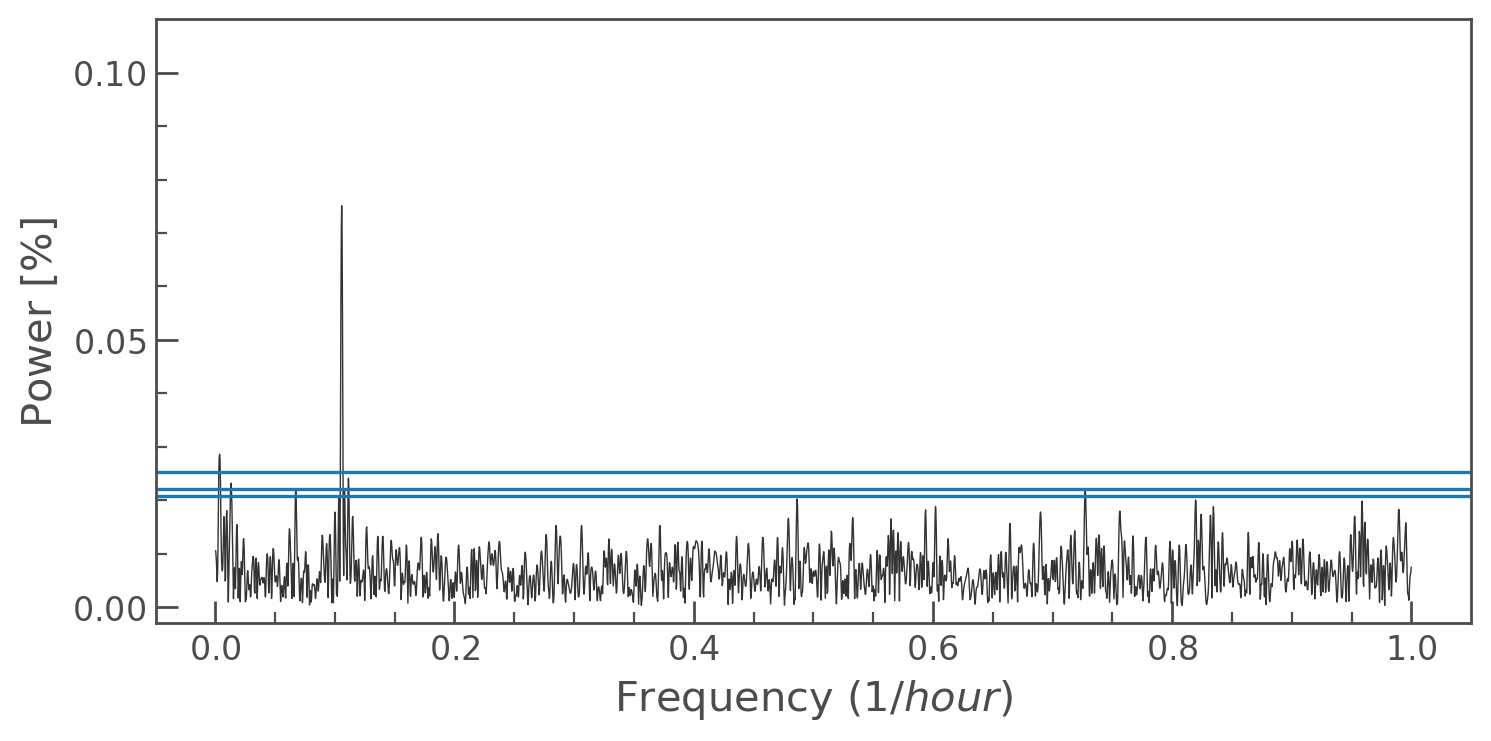

In [144]:
pg = norm_lk.to_periodogram()
ax = pg.plot(view='frequency', unit=1/u.hour, xlabel=r'Frequency $(1/hour)$')
ax.set_ylim(-0.003, 0.11)
ax.set_yticks(np.arange(0,0.11,0.05))

# To get some understanding of the noise, we need to go a bit lower level and look at the astropy implementation
ls = LombScargle(lk.time, lk.flux, lk.flux_err)
power = ls.power(frequency=pg.frequency.value)
# fap_num = ls.false_alarm_probability(power.max(), method='bootstrap')
probabilities = [0.1, 0.05, 0.01]
for probability in probabilities:
    line = ls.false_alarm_level(probability)
    print(f"This tells us that to attain a {probability*100:0.0f} per cent false alarm probability requires the highest periodogram peak to be approximately {line:0.3f}")
    ax.axhline(line)

plt.show()

In [71]:
period_peak = pg.period_at_max_power
power_peak = pg.max_power
print(period_peak.to(u.hour), power_peak)

9.45933121390323 h 0.07509156162170295 %


Now using MCMC to find the best fitting sinusoid function

In [27]:
def model_func(theta, x):
    amp, period, phase = theta
    frequency = (2*np.pi)/(period)
    return amp * np.sin(frequency * x - phase*frequency) + 100

def log_likelihood(theta, x, y, yerr):
    model = model_func(theta, x)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / yerr ** 2)

def log_prior(theta):
    amp, frequency, phase = theta
    # Require physical amplitude and frequency
    if 0 < amp and 0 < frequency:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

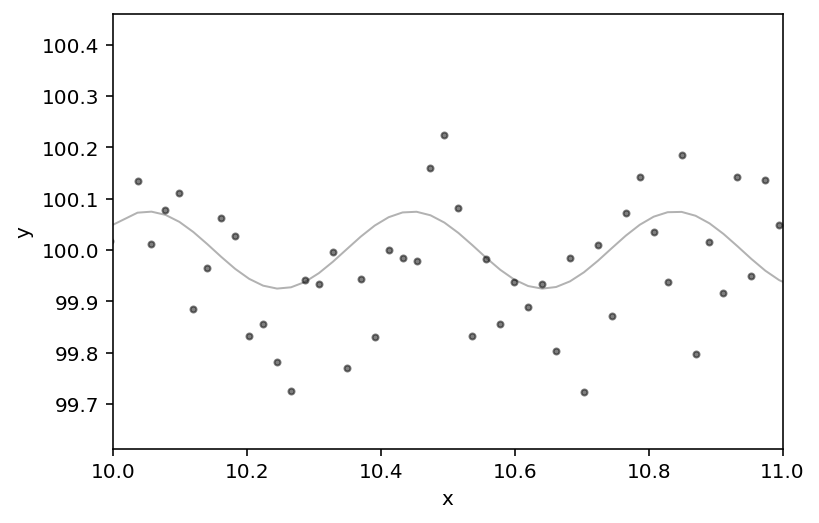

In [28]:
# np.random.seed(23213)

# Choose the "true" parameters.
amp_true = power_peak.value
period_true = period_peak.to(u.day).value
phase_true = 0.1 #This has units of days

x0 = np.linspace(np.min(norm_lk.time),
                 np.max(norm_lk.time),
                 10000)
x = norm_lk.time
y = norm_lk.flux
yerr = norm_lk.flux_err

plt.errorbar(x, y, yerr=0, fmt=".k", capsize=0, alpha=0.5)
plt.plot(x, model_func([amp_true, period_true, phase_true],x),
         "k", alpha=0.3, lw=1)

plt.xlim(0+10, 1+10)
plt.xlabel("x")
plt.ylabel("y");

In [29]:
pos = [amp_true, period_true, phase_true] + 1e-4 * np.random.randn(100, 3)
# pos = beers_theta + 1e-4 * np.random.randn(100, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [00:12<00:00, 161.02it/s]


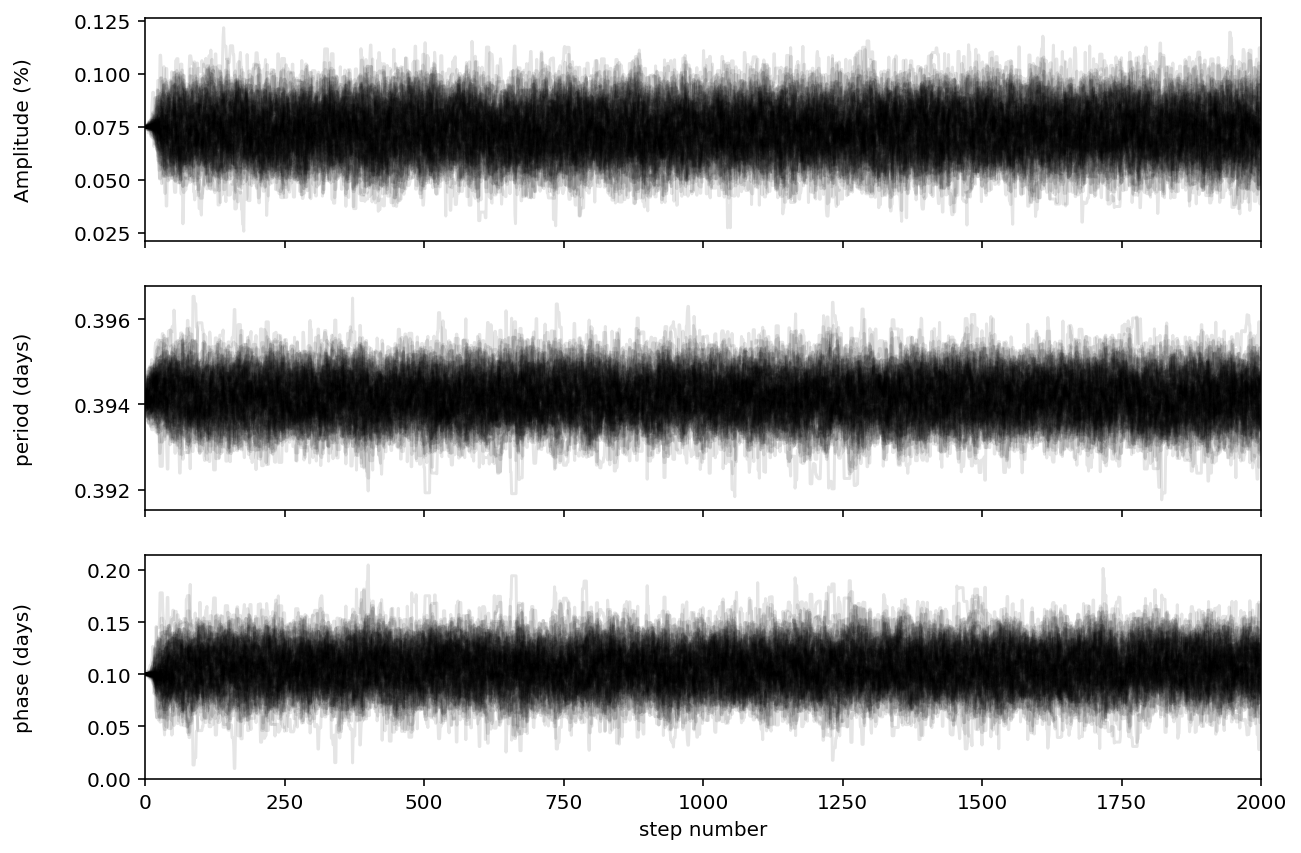

In [30]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Amplitude (%)", "period (days)", "phase (days)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [31]:
tau = sampler.get_autocorr_time()
print(tau)

[34.71154165 31.35790967 31.99577403]


In [32]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(12600, 3)


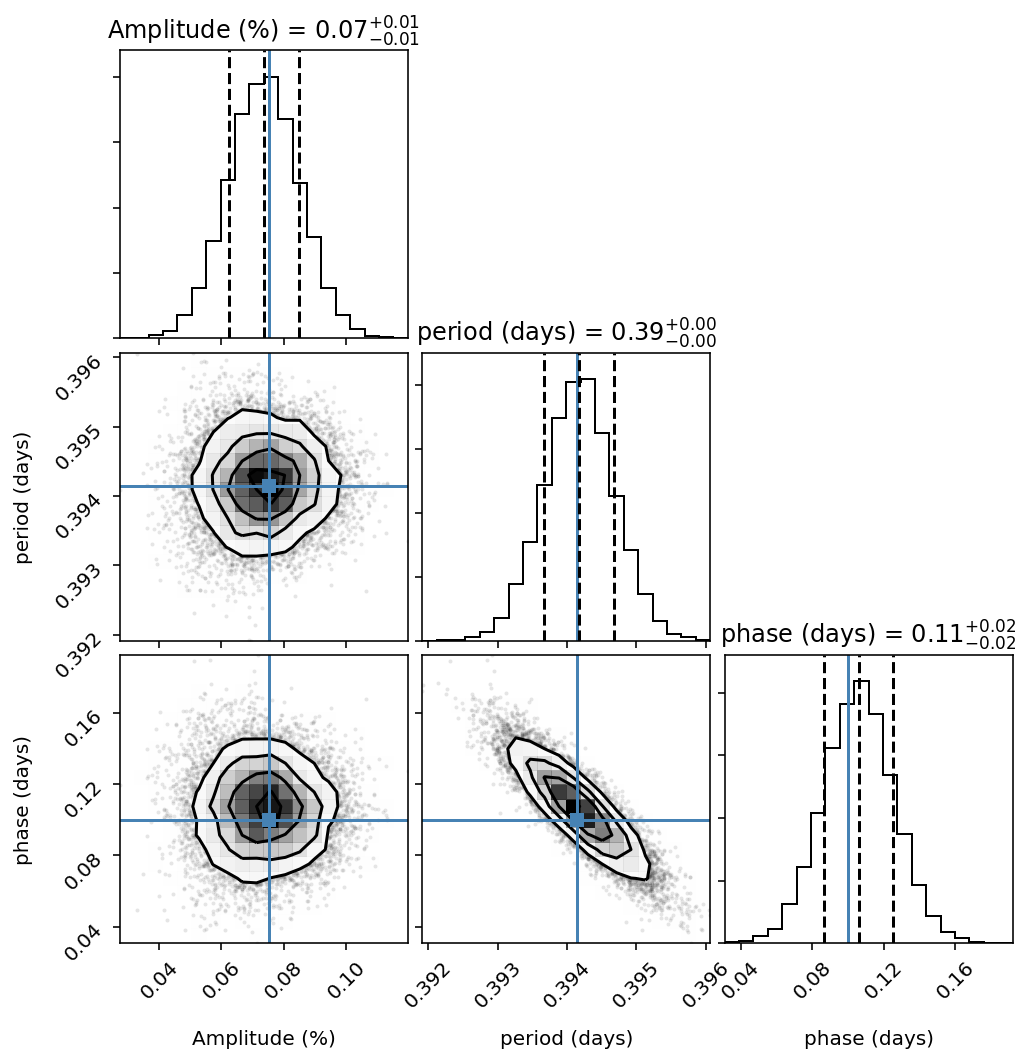

In [33]:
fig = corner.corner(
    flat_samples, show_titles=True, quantiles=[0.16, 0.5, 0.84],
    labels=labels, truths=[amp_true, period_true, phase_true]
);

So the best guesses weren't too bad

In [80]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    if i==1:
        mcmc *= 24
    mcmc_diff = np.diff(mcmc)
    txt = "$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], mcmc_diff[0], mcmc_diff[1], labels[i])
    print(Math(txt).data)

$\mathrm{Amplitude (%)} = 0.074_{-0.011}^{0.011}$
$\mathrm{period (days)} = 9.460_{-0.012}^{0.012}$
$\mathrm{phase (days)} = 0.106_{-0.020}^{0.019}$


Now to make the final plot for the paper

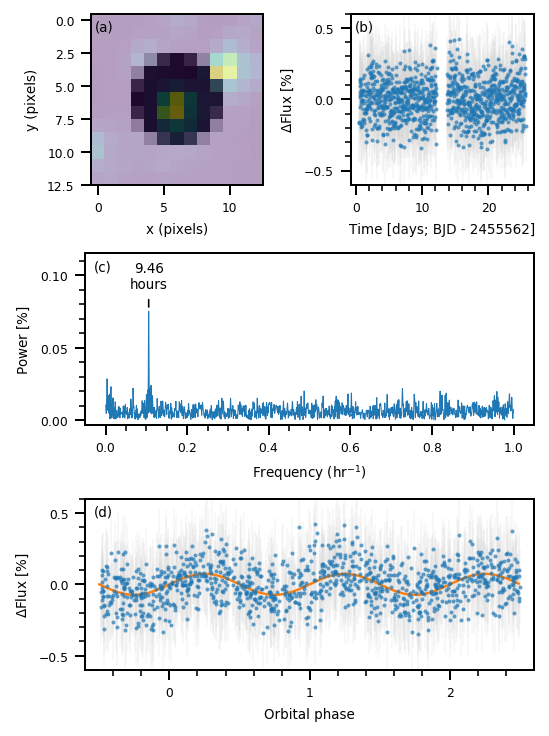

In [149]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

lk = LC(data.time[q & useful_cadences] - 1438,
        data.corr_flux[q & useful_cadences],
        (data.flux_err/data.raw_flux*data.flux_err)[q & useful_cadences])


# asssn = pd.read_csv("/Users/jeffrey/Downloads/AP22985891.csv")
# lk_asssn = LC(asssn.sort_values('hjd').hjd, asssn.sort_values('hjd').mag, asssn.sort_values('hjd')['mag err'])

sns.set_context("paper", font_scale=0.7)

fig = plt.figure(constrained_layout=True, figsize=(3.7,5))
# fig = plt.figure(0)
gs = fig.add_gridspec(nrows=3, ncols=2)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,:])
error_kwargs = dict(fmt='.', ecolor='lightgray', elinewidth=0.2, markersize=4., alpha=0.7, markeredgewidth=0)

# Plot the star image
cm = ax1.imshow(data.tpf[300], vmin=100, vmax=350)
ax1.imshow(data.all_apertures[16], cmap='Greys', alpha=0.6)
ax1.set_xlabel('x (pixels)')
ax1.set_ylabel('y (pixels)')

# Plot the lightcurve
# norm_lk = lk.normalize(unit='percent')
norm_lk.flux -= 100
norm_lk.errorbar(ax=ax3,
                 xlabel=f'Time [days; BJD - {2457000-1438}]',
                 **error_kwargs)
norm_lk.flux += 100

# Plot the periodogram
pg.plot(ax=ax2, view='frequency', unit=1/u.hour, xlabel='Frequency (hr$^{-1})$')
ax2.set_ylim(-0.003, 0.115)
ax2.set_yticks(np.arange(0,0.11,0.05))

# ax2.set_xscale('log')
# ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
# ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
period = np.median(flat_samples[:,1]) * u.day
max_power = np.median(flat_samples[:,0])
phase = np.median(flat_samples[:,2]) * u.day

ax2.annotate(f"{period.to(u.hour).value:0.2f}\nhours",
             xy=(1/(period.to(u.hour)).value, max_power+0.0016),
             xytext=(1/(period.to(u.hour)).value, max_power+0.0171),
             xycoords='data', ha='center', arrowprops=dict(arrowstyle="-"))

# Plot the folded light curve
folded_lk = norm_lk.fold(period=period, t0=phase)
ax4.errorbar(folded_lk.phase + np.random.randint(0, high=3, size=len(folded_lk.phase)),
             folded_lk.flux - 100,
             yerr = folded_lk.flux_err,
             **error_kwargs)
ax4.set_xticks(np.arange(0, +3.1, 1.))
ax4.set_ylabel('Flux [%]')
ax4.set_xlabel("Orbital phase")
phase_array = np.arange(-0.5,2.5,0.01)
ax4.set_xlim(-0.6,2.6)
ax4.plot(phase_array, model_func([max_power, 1, 0], phase_array)-100, 'C1')


for ax in [ax3, ax4]:
    ax.minorticks_on()
    ax.set_yticks(np.arange(-0.5, 0.6, 0.5))
    ax.set_ylim(-0.6,0.6)
    ax.set_ylabel(r'$\Delta$Flux [%]')

[ax.annotate(text, xy=(0.02,0.9), xycoords='axes fraction') 
 for ax, text in [[ax1,"(a)"], [ax2,"(c)"], [ax3,"(b)"], [ax4,"(d)"]]]
# fig.tight_layout()
fig.savefig('tess_elm_light_curve.pdf')